In [1]:
import uproot as ur
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import awkward as ak
import mplhep as hep
import ROOT
hep.style.use("CMS")

In [2]:
data_directory = "/global/homes/r/rmilton/m3246/rmilton/H1Unfold/jet_data/"
file_name = "Rapgap_kt_lab_Julyclosure_it9_nocuts_0ptcut_1consituentcut_1mil.root"
with ur.open("{file}:gen_jets".format(file=data_directory+file_name)) as out:
    kt_jets = out.arrays(["eta", "px", "py", "pz", "E", "pT", "phi"])
    print("Number of events:",out.num_entries)
with ur.open("{file}:gen_event".format(file=data_directory+file_name)) as event:
    kt_event_info = event.arrays(["q_x","q_y", "q_z", "q_E", "Q2", "y", "elec_pT","elec_eta","elec_phi", "weight", "step2_weights"])
    print("Number of events:",event.num_entries)

Number of events: 1000000
Number of events: 1000000


In [3]:
file_name = "Rapgap_centauro_breit_Julyclosure_it9_nocuts_1consituentcut.root"
with ur.open("{file}:gen_jets".format(file=data_directory+file_name)) as out:
    centauro_jets = out.arrays(["eta", "px", "py", "pz", "E", "pT", "phi"])
    print("Number of events:",out.num_entries)
with ur.open("{file}:gen_event".format(file=data_directory+file_name)) as event:
    centauro_event_info = event.arrays(["Q2", "y", "elec_pT","elec_eta","elec_phi", "weight", "step2_weights"])
    print("Number of events:",event.num_entries)

Number of events: 100000
Number of events: 100000


In [4]:
def remove_zero_jets(events, jets, use_q = False, jetpT_cut=0, event_mask = None):
    if event_mask is not None:
        events = event_info[event_mask]
        jets = jets[event_mask]
    
    jet_mask = (jets["pT"] > jetpT_cut)
    broadcasted_weights = []

    num_jets_per_event = len(jet_mask[0])

    event_index = np.arange(len(events))
    event_index = np.concatenate([np.repeat(index, num_jets_per_event) for index in event_index])
    event_index = np.array(event_index)[ak.flatten(jet_mask)]
    
    jet_multiplicity = ak.sum(jet_mask, axis=1)
    event_weights = np.concatenate([np.repeat(event_weight, num_jets_per_event) for event_weight in events["weight"]])
    event_weights = np.array(event_weights)[ak.flatten(jet_mask)]
    
    step2_weights = np.concatenate([np.repeat(unfolded_weight, num_jets_per_event) for unfolded_weight in events["step2_weights"]])
    step2_weights = np.array(step2_weights)[ak.flatten(jet_mask)]
    
    event_Q2 = np.concatenate([np.repeat(Q2, num_jets_per_event) for Q2 in events["Q2"]])
    event_Q2 = np.array(event_Q2)[ak.flatten(jet_mask)]

    event_y = np.concatenate([np.repeat(y, num_jets_per_event) for y in events["y"]])
    event_y = np.array(event_y)[ak.flatten(jet_mask)]

    event_elec_pT = np.concatenate([np.repeat(pT, num_jets_per_event) for pT in events["elec_pT"]])
    event_elec_pT = np.array(event_elec_pT)[ak.flatten(jet_mask)]

    event_elec_phi = np.concatenate([np.repeat(phi, num_jets_per_event) for phi in events["elec_phi"]])
    event_elec_phi = np.array(event_elec_phi)[ak.flatten(jet_mask)]

    event_elec_eta = np.concatenate([np.repeat(eta, num_jets_per_event) for eta in events["elec_eta"]])
    event_elec_eta = np.array(event_elec_eta)[ak.flatten(jet_mask)]

    if use_q:
        event_qx = np.concatenate([np.repeat(qx, num_jets_per_event) for qx in events["q_x"]])
        event_qx = np.array(event_qx)[ak.flatten(jet_mask)]
    
        event_qy = np.concatenate([np.repeat(qy, num_jets_per_event) for qy in events["q_y"]])
        event_qy = np.array(event_qy)[ak.flatten(jet_mask)]
    
        event_qz = np.concatenate([np.repeat(qz, num_jets_per_event) for qz in events["q_z"]])
        event_qz = np.array(event_qz)[ak.flatten(jet_mask)]
    
        event_qE = np.concatenate([np.repeat(qE, num_jets_per_event) for qE in events["q_E"]])
        event_qE = np.array(event_qE)[ak.flatten(jet_mask)]
    
    print(len(event_weights), len(step2_weights), len(event_Q2))
    selected_jets = jets[jet_mask]
    flattened_eta = selected_jets["eta"]
    flattened_px = selected_jets["px"]
    flattened_py = selected_jets["py"]
    flattened_pz = selected_jets["pz"]
    flattened_pT = selected_jets["pT"]
    flattened_E = selected_jets["E"]
    flattened_phi = selected_jets["phi"]
    print(len(flattened_phi), len(flattened_eta))
    if use_q:
        out = {"event_index":event_index,"jet_multiplicity":jet_multiplicity, "jet_eta":flattened_eta, "jet_px":flattened_px, "jet_py":flattened_py, "jet_pz":flattened_pz, "jet_E":flattened_E, "jet_phi":flattened_phi, "jet_pT":flattened_pT, "q_x": event_qx, "q_y":event_qy, "q_z":event_qz, "q_E":event_qE, "Q2":event_Q2, "y":event_y, "elec_pT":event_elec_pT, "elec_phi":event_elec_phi, "elec_eta":event_elec_eta, "weights":event_weights, "step2_weights":step2_weights}
    else:
        out = {"event_index":event_index,"jet_multiplicity":jet_multiplicity, "jet_eta":flattened_eta, "jet_px":flattened_px, "jet_py":flattened_py, "jet_pz":flattened_pz, "jet_E":flattened_E, "jet_phi":flattened_phi, "jet_pT":flattened_pT, "Q2":event_Q2, "y":event_y, "elec_pT":event_elec_pT, "elec_phi":event_elec_phi, "elec_eta":event_elec_eta, "weights":event_weights, "step2_weights":step2_weights}
    return out
filtered_kt = remove_zero_jets(kt_event_info, kt_jets, use_q=True)
filtered_centauro = remove_zero_jets(centauro_event_info, centauro_jets)

3686825 3686825 3686825
3686825 3686825
254707 254707 254707
254707 254707


In [5]:
def get_z_jet(data, breit = False):
    z_jet_array =  []
    Q_array = np.sqrt(data["Q2"])
    if breit:
        n = ROOT.TLorentzVector()
        n.SetPxPyPzE(0, 0, 1, 1)
        for i, (jet_px, jet_py, jet_pz, jet_E, Q) in enumerate(zip(data["jet_px"], data["jet_py"], data["jet_pz"], data["jet_E"], Q_array)):
            jet_vec = ROOT.TLorentzVector()
            jet_vec.SetPxPyPzE(jet_px, jet_py, jet_pz, jet_E)
            z_jet = n.Dot(jet_vec) / Q
            z_jet_array.append(z_jet)
    else:
        elec_px = data["elec_pT"] * np.cos(data["elec_phi"])
        elec_py = data["elec_pT"] * np.sin(data["elec_phi"])
        elec_pz = data["elec_pT"] * np.sinh(data["elec_eta"])
        elec_p = np.sqrt(elec_px**2 + elec_py**2 + elec_pz**2)
        elec_theta = np.arccos(elec_pz/elec_p)
        # x_array = elec_p * (1 + np.cos(elec_theta))/(2*data["y"])
        for (jet_px, jet_py, jet_pz, jet_E, qx, qy, qz, qE) in zip(data["jet_px"], data["jet_py"], data["jet_pz"], data["jet_E"], data["q_x"], data["q_y"], data["q_z"], data["q_E"]):
            q_vec = ROOT.TLorentzVector()
            q_vec.SetPxPyPzE(qx,qy, qz, qE)
            P = ROOT.TLorentzVector()
            P.SetPxPyPzE(0, 0, 920, 920)
            jet_vec = ROOT.TLorentzVector()
            jet_vec.SetPxPyPzE(jet_px, jet_py, jet_pz, jet_E)
            z_jet = P.Dot(jet_vec)/P.Dot(q_vec)
            z_jet_array.append(z_jet)
    z_jet_array = ak.Array(z_jet_array)
    data["z_jet"] = z_jet_array
    return data
filtered_kt = get_z_jet(filtered_kt, breit=False)
filtered_centauro = get_z_jet(filtered_centauro, breit=True)

In [6]:
print(np.unique(filtered_kt["event_index"]))

[     0      1      2 ... 999997 999998 999999]


In [31]:
num_delta_z = min(len(centauro_event_info), len(kt_event_info))
filtered_kt["z_jet_max"] = []
for index in range(num_delta_z):
    event_mask = filtered_kt["event_index"]==index
    event_z = filtered_kt["z_jet"][event_mask]
    max_z = np.max(event_z)
    filtered_kt["z_jet_max"].append(max_z)    
filtered_kt["z_jet_max"] = np.array(filtered_kt["z_jet_max"],dtype=np.float32)

filtered_centauro["z_jet_max"] = []
for index in range(num_delta_z):
    event_mask = filtered_centauro["event_index"]==index
    event_z = filtered_centauro["z_jet"][event_mask]
    max_z = np.max(event_z)
    filtered_centauro["z_jet_max"].append(max_z)   
filtered_centauro["z_jet_max"] = np.array(filtered_centauro["z_jet_max"],dtype=np.float32)

In [45]:
print(len(filtered_centauro["z_jet_max"]), len(filtered_kt["z_jet_max"]))
empty_jet_mask = (~np.isnan(filtered_kt["z_jet_max"])) & (~np.isnan(filtered_centauro["z_jet_max"]))
delta_z = np.subtract(filtered_kt["z_jet_max"][empty_jet_mask], filtered_centauro["z_jet_max"][empty_jet_mask])
      

100000 100000


In [49]:
def calculate_Q2(data):
    Q2_from_q = -1*(data["q_E"]*data["q_E"] - data["q_x"]*data["q_x"] - data["q_y"]*data["q_y"] - data["q_z"]*data["q_z"])
    elec_px = data["elec_pT"] * np.cos(data["elec_phi"])
    elec_py = data["elec_pT"] * np.sin(data["elec_phi"])
    elec_pz = data["elec_pT"] * np.sinh(data["elec_eta"])
    elec_p = np.sqrt(elec_px**2 + elec_py**2 + elec_pz**2)
    elec_theta = np.arccos(elec_pz/elec_p)
    mask = data["y"]<1
    ISigma_Q2 = (elec_p*elec_p*np.sin(elec_theta)*np.sin(elec_theta))/(1-data["y"])
    ISigma_Q2 = ISigma_Q2[mask]
    return Q2_from_q, ISigma_Q2

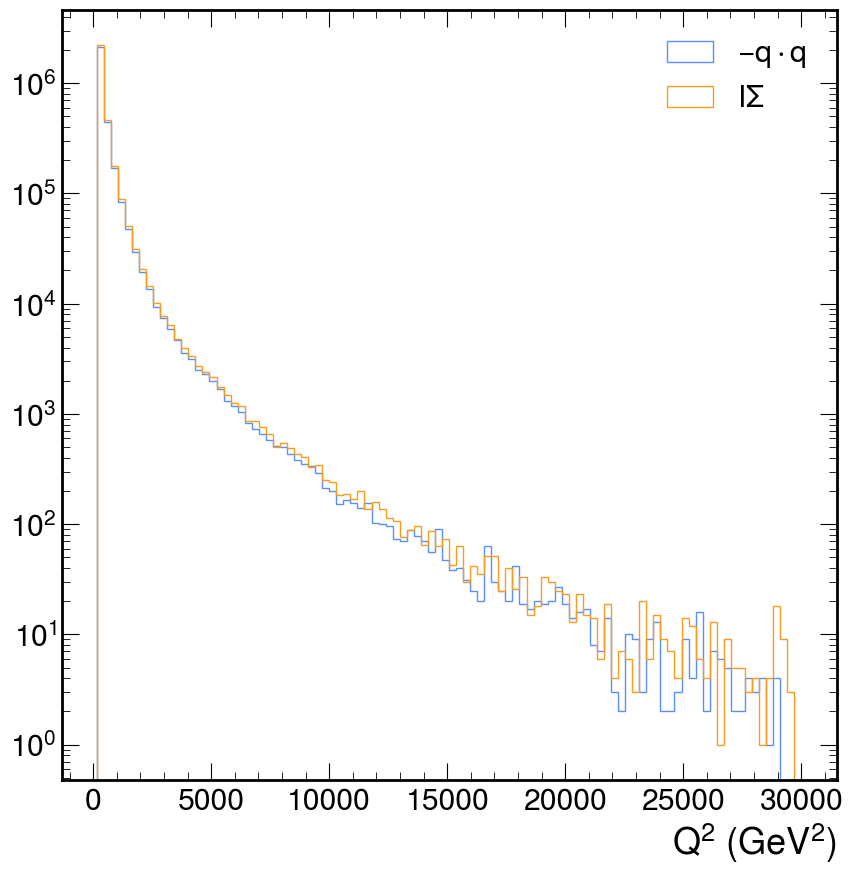

In [50]:
Q2_from_q, ISigma_Q2 = calculate_Q2(filtered_kt)
plt.hist(Q2_from_q, bins=100, range=(150, 30000), histtype="step", label="$-q \cdot q$")
plt.hist(ISigma_Q2, bins=100, range=(150, 30000), histtype="step", label="$I\Sigma$")
plt.yscale('log')
plt.xlabel("$Q^2~(GeV^2)$")
plt.legend()

(-1.0, 30.0)

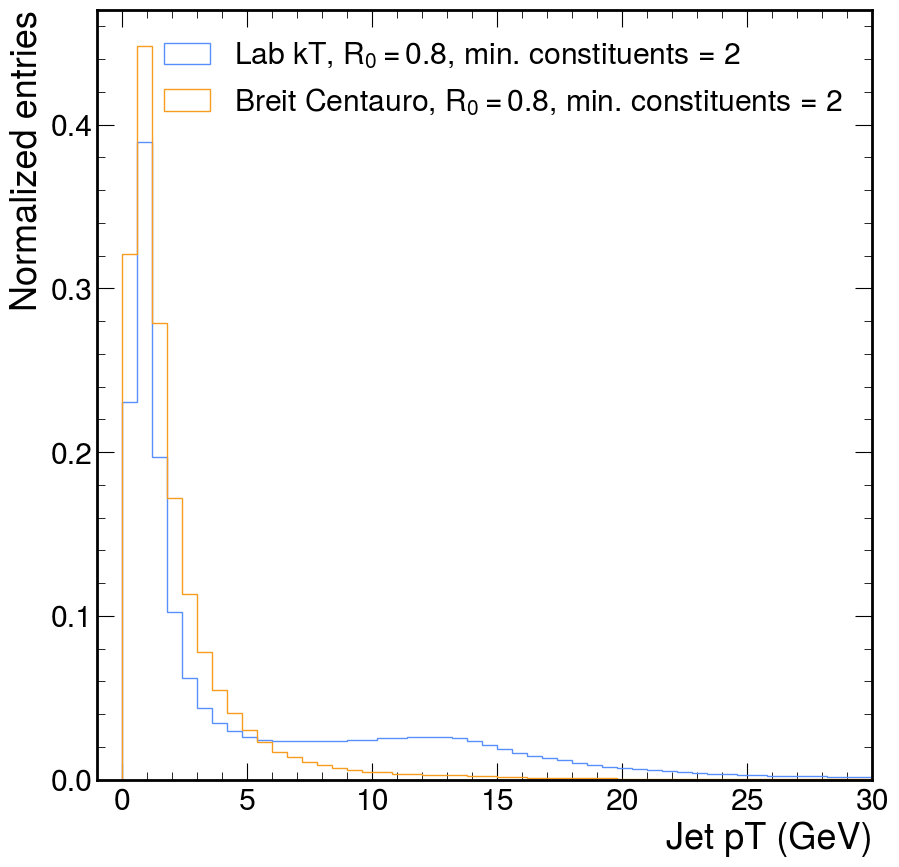

In [96]:
plt.hist(filtered_kt["jet_pT"], weights=filtered_kt["weights"], bins=50, density=True, label="Lab kT, $R_0=0.8$, min. constituents = 2", range=(0,30), histtype='step')
plt.hist(filtered_centauro["jet_pT"], weights=filtered_centauro["weights"], bins=50, density=True, range=(0,30), label="Breit Centauro, $R_0=0.8$, min. constituents = 2", histtype='step')
plt.xlabel("Jet pT (GeV)")
plt.ylabel("Normalized entries")
plt.legend()
# plt.ylim(0,.1)
plt.xlim(-1,30)

Text(1, 0, 'Jet multiplicty')

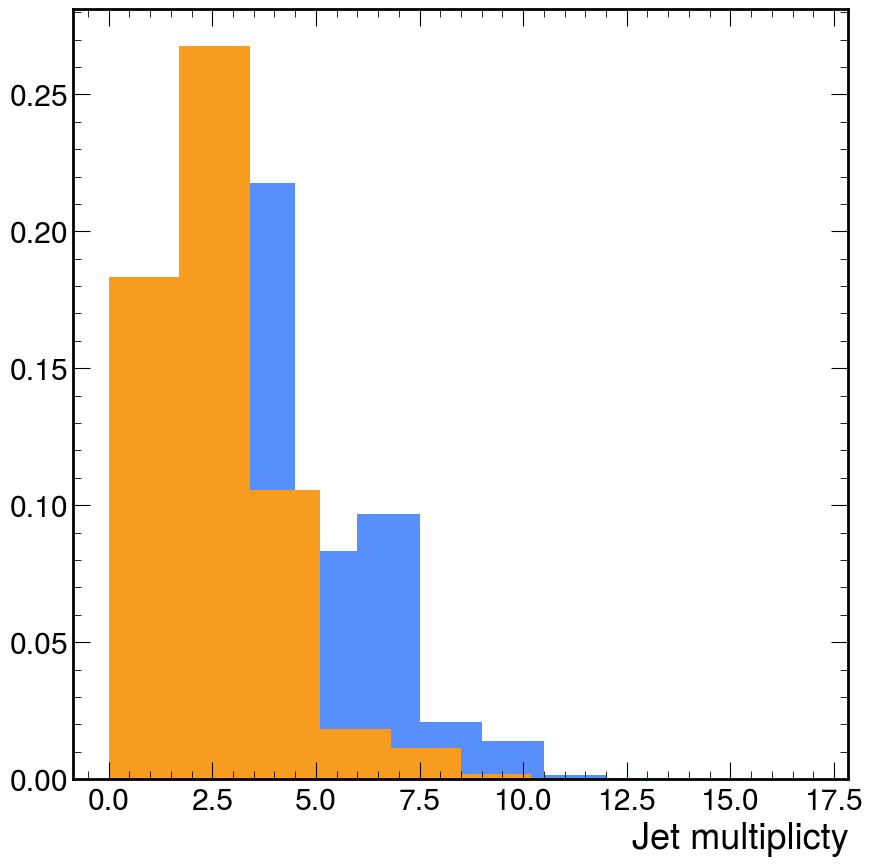

In [52]:
plt.hist(filtered_kt["jet_multiplicity"], bins=10, density=True)
plt.hist(filtered_centauro["jet_multiplicity"], bins=10, density=True)
plt.xlabel("Jet multiplicty")

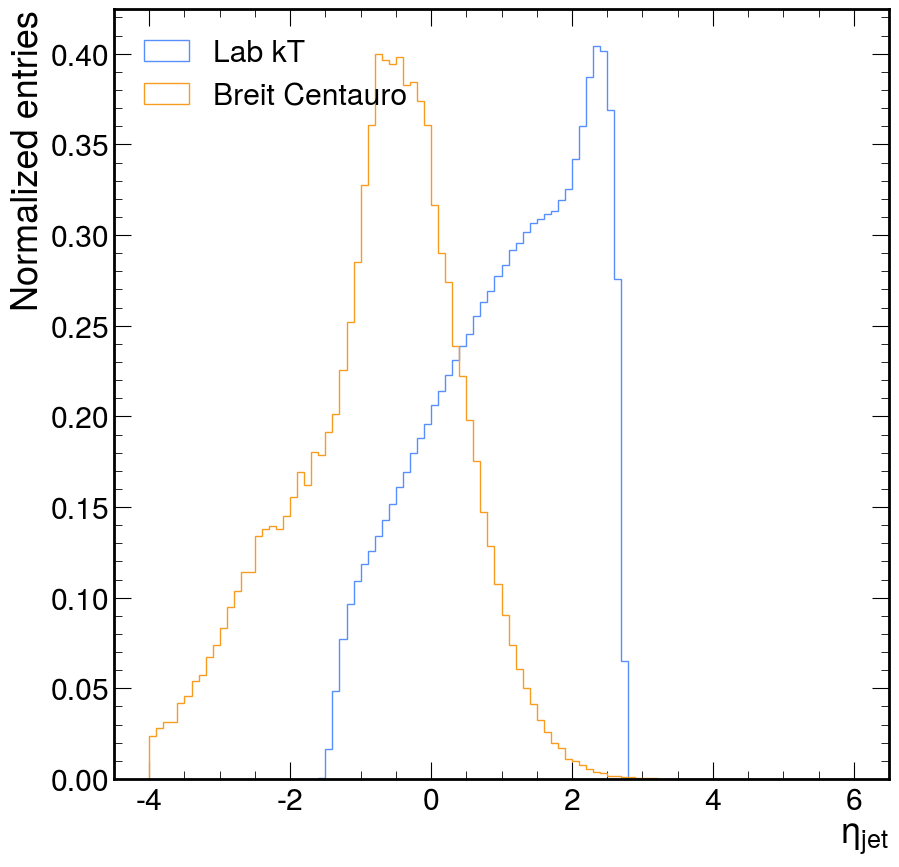

In [53]:
plt.hist(filtered_kt["jet_eta"], weights = filtered_kt["weights"], bins=100, label="Lab kT", density=True, range=(-4,6), histtype='step')
plt.hist(filtered_centauro["jet_eta"], weights = filtered_centauro["weights"], bins=100, label="Breit Centauro", range=(-4,6), density=True, histtype='step')
plt.xlabel("$\eta_{jet}$")
plt.ylabel("Normalized entries")
plt.legend(loc='upper left')

Text(0.5, 1.0, 'Rapgap Truth Level')

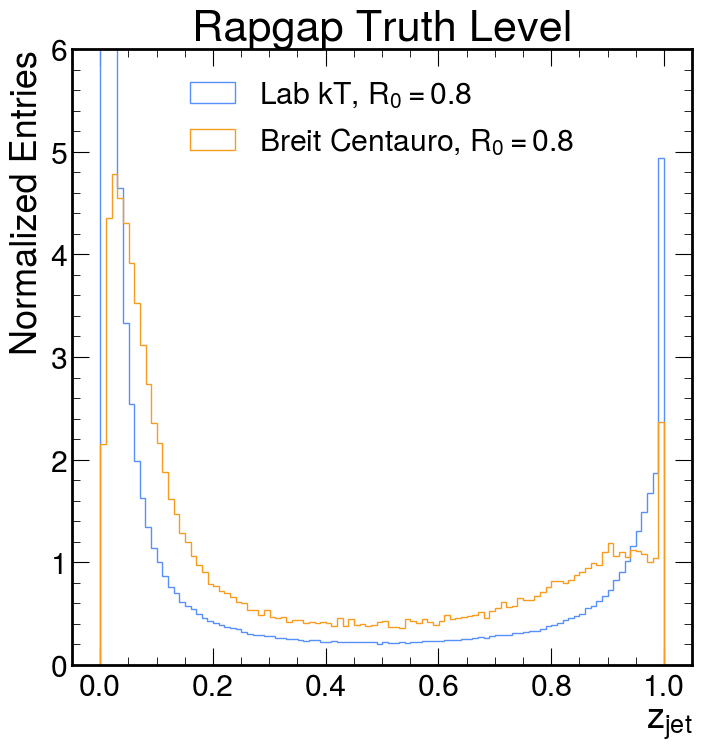

In [106]:
fig = plt.figure(figsize=(8,8))
kt_entries, kt_bins, _ = plt.hist(filtered_kt["z_jet"], weights= filtered_kt["weights"]*filtered_kt["step2_weights"], bins = 100, label="Lab kT, $R_0=0.8$", histtype='step',density=True)
centauro_entries, centauro_bins, _ = plt.hist(filtered_centauro["z_jet"], weights= filtered_centauro["weights"]*filtered_centauro["step2_weights"], bins = 100, label="Breit Centauro, $R_0=0.8$",histtype='step',density=True)
plt.xlabel("$z_{jet}$")
plt.ylabel("Normalized Entries")
plt.ylim(0,6)
# plt.xlim(0,2)
plt.legend()
plt.title("Rapgap Truth Level")

In [79]:
print(centauro_event_info["weight"][:num_delta_z])
print(kt_event_info["weight"][:num_delta_z])
# print(np.array_equal(

[1.23, 1.4, 1.64, 0.795, 0.795, 1.24, ..., 1.04, 0.876, 0.795, 1.52, 0.795, 2.2]
[1.24, 1.41, 1.64, 0.798, 0.798, 1.25, ..., 0.879, 0.798, 1.53, 0.798, 2.21]


In [71]:
centauro_event_info["weight"] = np.asarray(centauro_event_info["weight"], dtype=np.float32)
print(centauro_event_info["weight"])
print(kt_event_info["weight"])
print(centauro_event_info["weight"][:num_delta_z][empty_jet_mask])
print(kt_event_info["weight"][:num_delta_z][empty_jet_mask])

[1.23, 1.4, 1.64, 0.795, 0.795, 1.24, ..., 1.04, 0.876, 0.795, 1.52, 0.795, 2.2]
[1.24, 1.41, 1.64, 0.798, 0.798, 1.25, ..., 0.798, 2.74, 0.92, 0.798, 0.824]
[1.23, 1.4, 1.64, 0.795, 0.795, 1.24, ..., 1.04, 0.876, 0.795, 1.52, 0.795, 2.2]
[1.24, 1.41, 1.64, 0.798, 0.798, 1.25, ..., 0.879, 0.798, 1.53, 0.798, 2.21]


Text(0, 1, 'Entries')

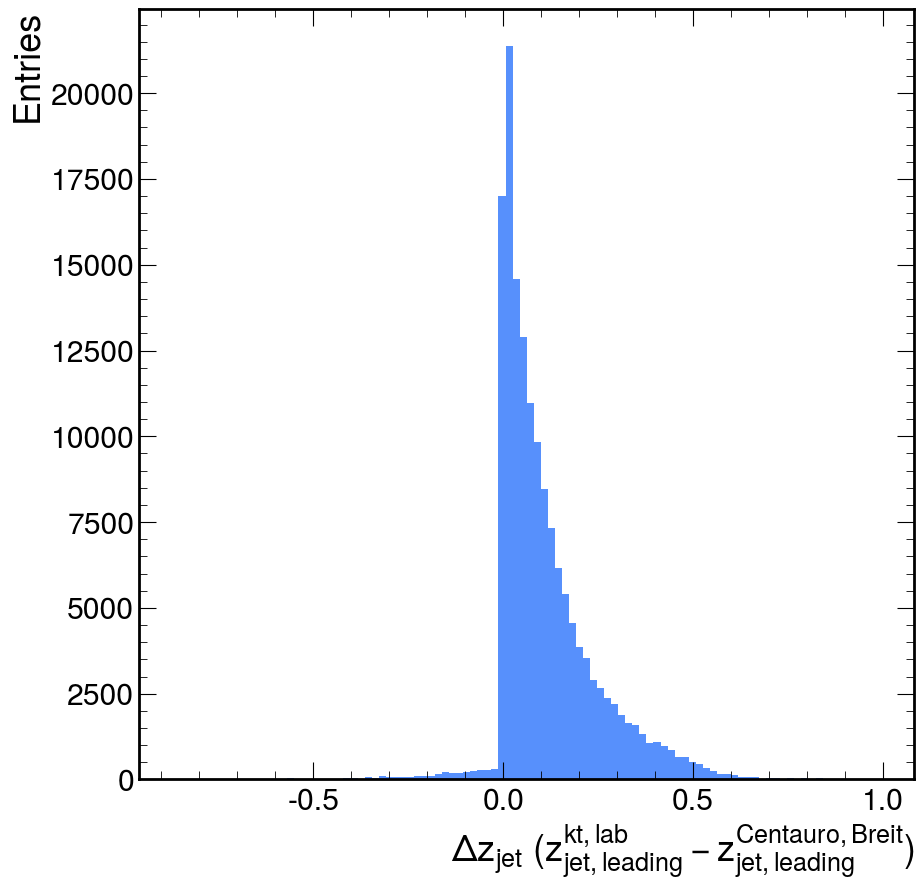

In [112]:
# if not np.array_equal(centauro_event_info["weight"][:num_delta_z][empty_jet_mask], kt_event_info["weight"][:num_delta_z][empty_jet_mask]):
#     print("Weight arrays not the same!")
plt.hist(delta_z, weights= centauro_event_info["weight"][empty_jet_mask]*centauro_event_info["step2_weights"][empty_jet_mask], bins=100)
plt.xlabel("$\Delta z_{jet}~(z_{jet, leading}^{kt, lab} - z_{jet, leading}^{Centauro, Breit})$")
plt.ylabel("Entries")

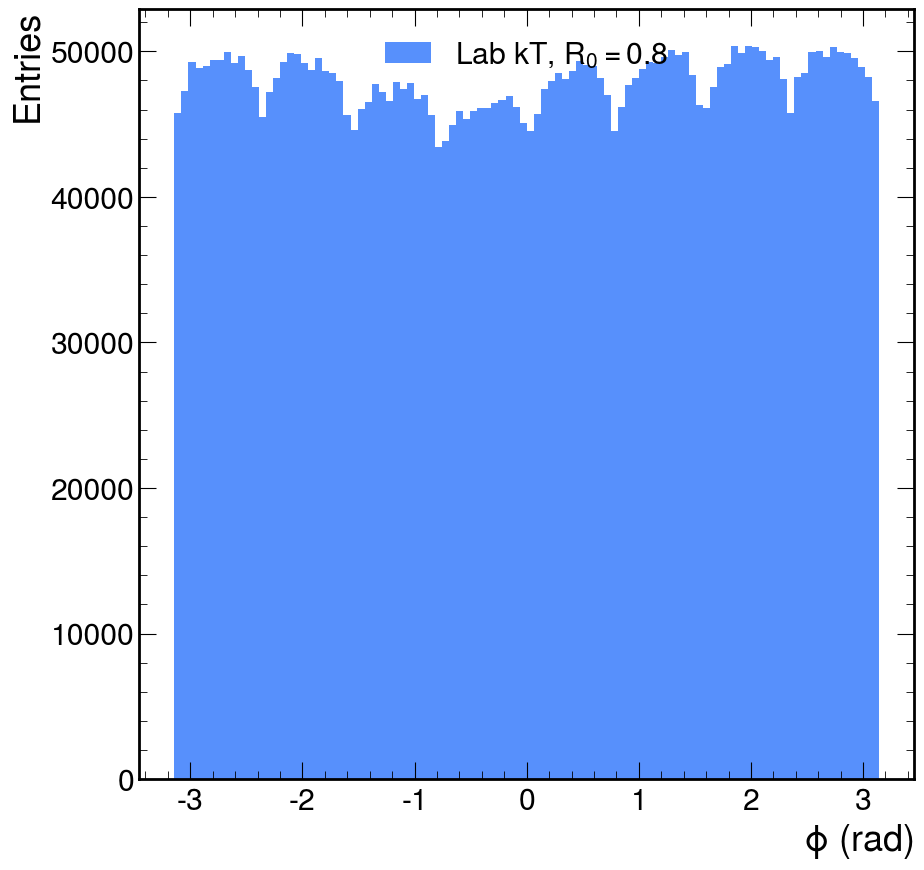

In [83]:
plt.hist(filtered_kt["jet_phi"], weights = filtered_kt["weights"], label="Lab kT, $R_0=0.8$", bins=100)
plt.xlabel("$\phi$ (rad)")
plt.ylabel("Entries")
plt.legend()

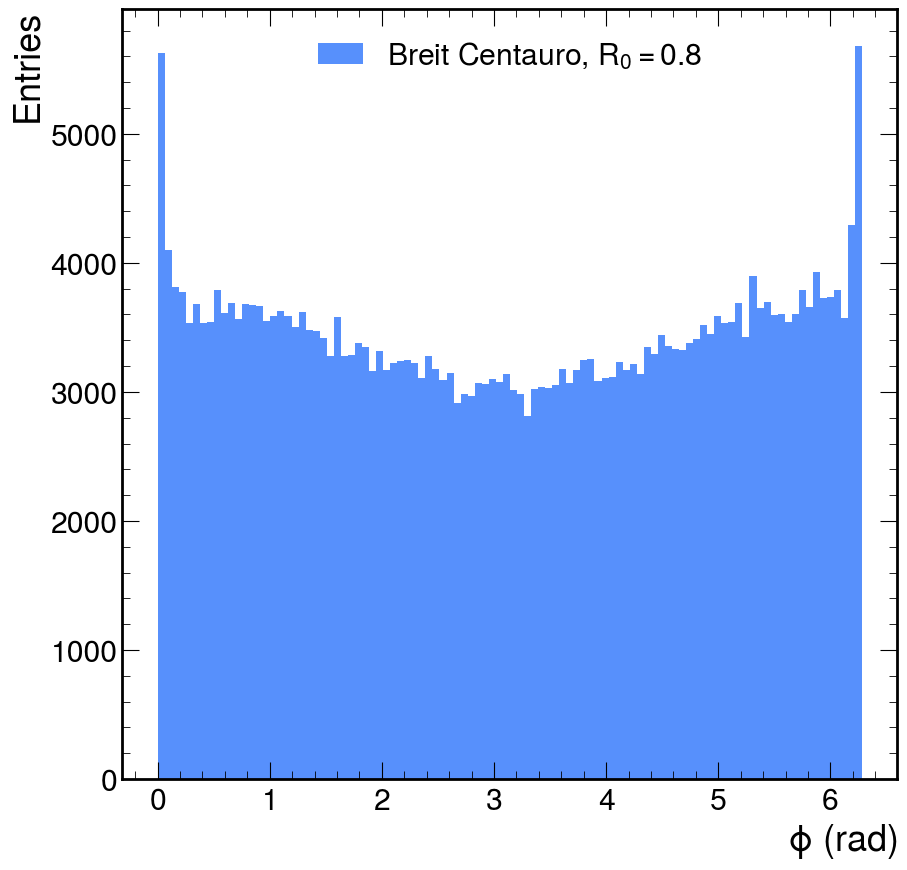

In [84]:
plt.hist(filtered_centauro["jet_phi"], weights = filtered_centauro["weights"], label="Breit Centauro, $R_0=0.8$", bins=100)
plt.xlabel("$\phi$ (rad)")
plt.ylabel("Entries")
plt.legend()

Text(0.5, 1.0, 'Lab kt $R_0$ = 0.8')

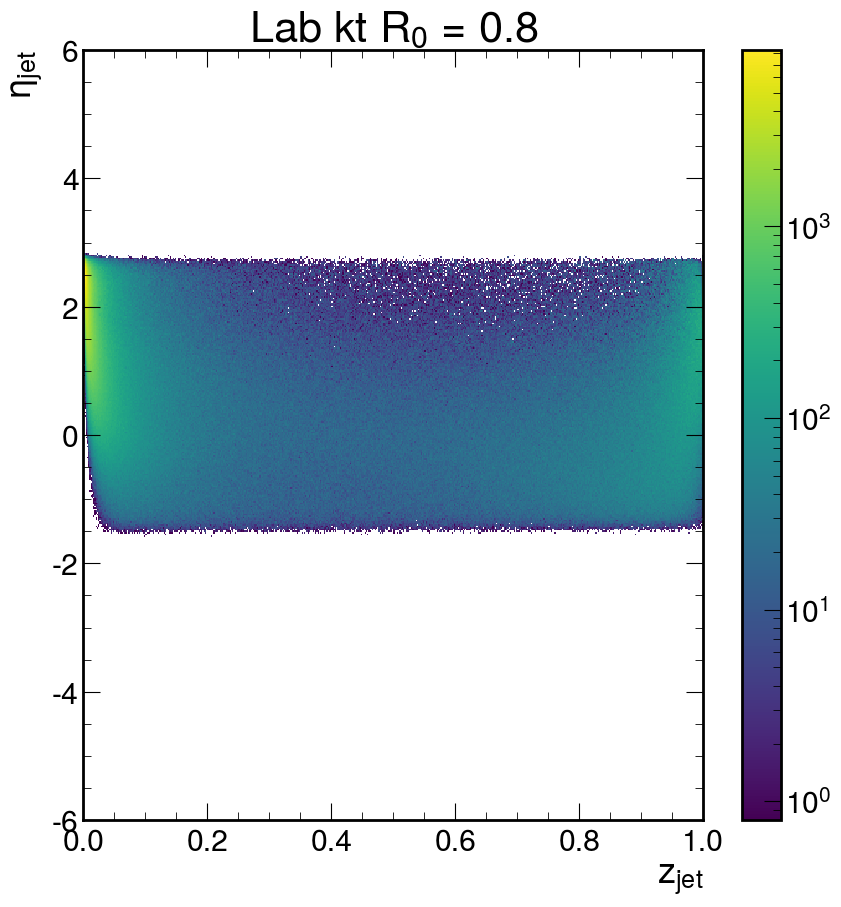

In [85]:
plt.hist2d(np.asarray(filtered_kt["z_jet"]), np.asarray(filtered_kt["jet_eta"]), weights = np.asarray(filtered_kt["weights"]), bins=(500,500), range=[(0, 1.0), (-6,6)], norm = colors.LogNorm())
plt.xlabel("$z_{jet}$")
plt.ylabel("$\eta_{jet}$")
plt.colorbar()
plt.title("Lab kt $R_0$ = 0.8")


Text(0.5, 1.0, 'Breit Centauro $R_0$ = 0.8')

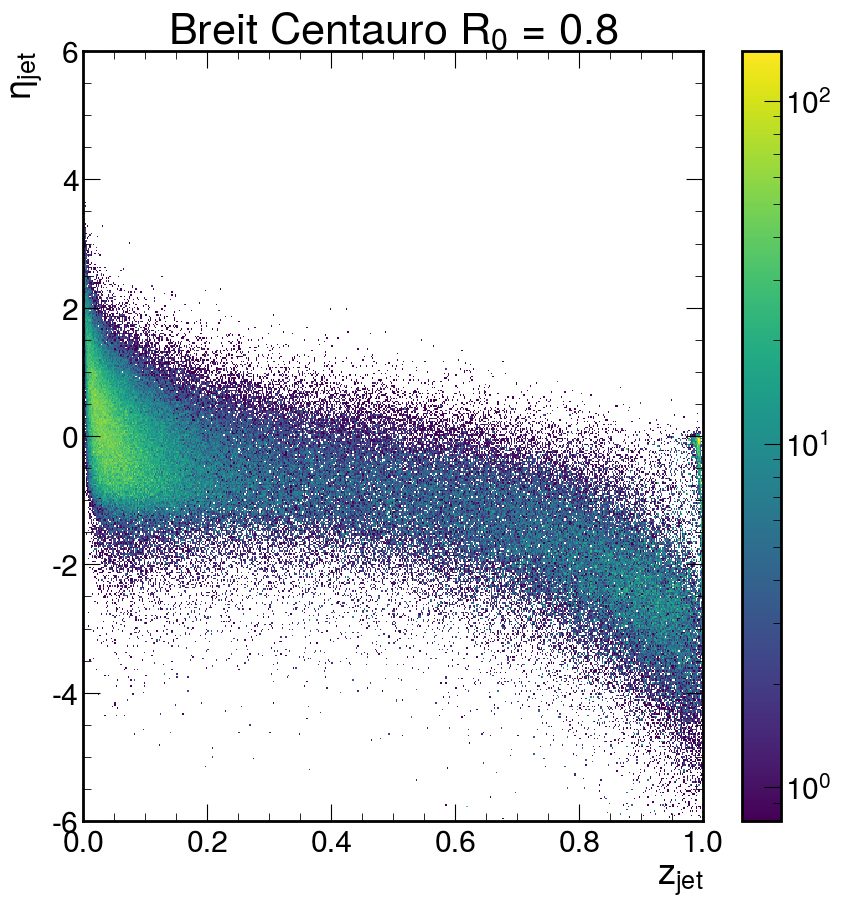

In [86]:
plt.hist2d(np.asarray(filtered_centauro["z_jet"]), np.asarray(filtered_centauro["jet_eta"]), weights = np.asarray(filtered_centauro["weights"]), bins=(500,500), range=[(0, 1.0), (-6,6)], norm = colors.LogNorm())
plt.xlabel("$z_{jet}$")
plt.ylabel("$\eta_{jet}$")
plt.colorbar()
plt.title("Breit Centauro $R_0$ = 0.8")
